# PCA on wholesale customers data.

## A customer segmentation analysis

The dataset used can be found [here](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers).
It is originated from a larger database referred on: 

*Abreu, N. (2011). Analise do perfil do cliente Recheio e desenvolvimento de um sistema promocional. Mestrado em Marketing, ISCTE-IUL, Lisbon*


In [84]:
import pandas as pd
dataset = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv'
df = pd.read_csv(dataset)

print('Number of variables:', df.shape[1], '\nNumber of observations:', df.shape[0])

Number of variables: 8 
Number of observations: 440


Variable description:

- FRESH: annual spending (m.u.) on fresh products (Continuous)
- MILK: annual spending (m.u.) on milk products (Continuous)
- GROCERY: annual spending (m.u.) on grocery products (Continuous)
- FROZEN: annual spending (m.u.) on frozen products (Continuous) 
- DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous) 
- DELICATESSEN: annual spending (m.u.) on and delicatessen products (Continuous) 
- CHANNEL: customers Channel - Horeca (Hotel/Restaurant/Cafe) or Retail channel (Nominal) 
- REGION: customers Region - Lisbon, Oporto or Other (Nominal) 

In [3]:
df.sample(5)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
141,1,3,30379,13252,5189,321,51,1450
329,1,2,5113,1486,4583,5127,492,739
281,2,3,12238,7108,6235,1093,2328,2079
144,1,3,18827,3677,1988,118,516,201
321,1,2,9155,1897,5167,2714,228,1113


In [22]:
# 1 - HoReCa
# 2 - Retail
df['Channel'].value_counts()

1    298
2    142
Name: Channel, dtype: int64

In [21]:
# 1 - Lisbon
# 2 - Oporto
# 3 - Other
df['Region'].value_counts()

3    316
1     77
2     47
Name: Region, dtype: int64

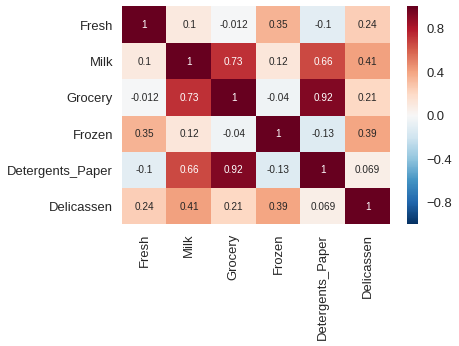

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
%matplotlib inline

# Subset to continous vars only (I'll deal with nominal vars later)
cont_vars = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

# Plot a correlation heatmap
sns.heatmap(df[cont_vars].corr(), annot=True)

In [5]:
# Descriptive stats for each variable

df[cont_vars].describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


Although values are all measured as annual spending, they have very disparate std (~13000 for Fresh, ~2800 for Delicassen) which calls for value scaling before undergoing PCA. 

In [24]:
from sklearn.preprocessing import scale

# Scale vars (with z-score)
X_std = scale(df[cont_vars], axis=0, with_mean=True, with_std=True, copy=True)

# Confirm if vars are scaled if == 1
np.std(X_std)

1.0

In [ ]:
from sklearn.decomposition import PCA

# Start PCA object and fit to data using sklearn library
pca = PCA()
pca.fit(X_std)

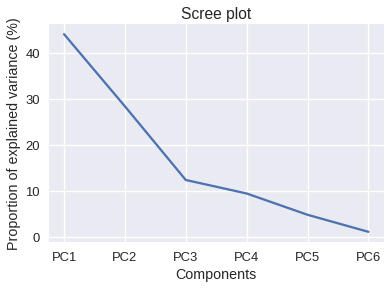

In [7]:
# Do a scree-plot to decide how many components to retain

expvar = pca.explained_variance_ratio_*100
plt.ylabel('Proportion of explained variance (%)')
plt.xlabel('Components')
ncomps = ['PC'+str(i+1) for i in range(0, pca.n_components_)]
plt.xticks(range(6), ncomps)
plt.title('Scree plot')
plt.plot(expvar)
plt.show()

The 'inflexion point' in the scree-plot is a rule of thumb on how many components to retain (also known as the 'elbow rule'). Based on the scree-plot I should retain the first three components. Lets check the proportion of variation of the original data these three components explain.

In [8]:
print('Proportion of explained variance by the three first components:', 
      expvar[0]+expvar[1]+expvar[2],'%')

Proportion of explained variance by the three first components: 84.7937053045 %


The first three components explain most of the variance (~85%) of the original dataset. That's fair enough. I'll retain these 3 components for further analysis.

### Loadings
Component loadings are the correlation between each component and the original variables. It is a measure of the variation of a variable that is explained by the component.

In [9]:
import numpy as np

# The interpretation of component loadings varies. Some rule of thumb say a value around 
# 0.5 is fair enough to be considered for loadings interpretation. I decided for 0.45.

def colordf(val):
    color = 'green' if val > 0.45 else 'red' if val < -0.45 else 'black'
    return('color: %s' % color)

loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_))
loadings.index = cont_vars
loadings.columns = ['PC'+str(i+1) for i in range(len(loadings.columns))]
s = loadings.style.applymap(colordf)
s

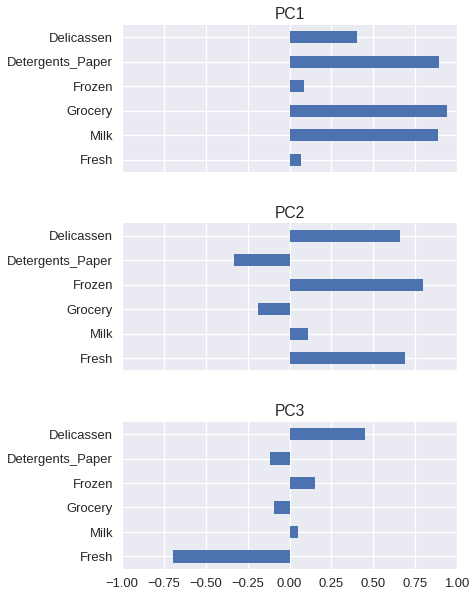

In [10]:
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
loadings['PC1'].plot(kind="barh", title="PC1", ax=ax1, figsize=(6,10))
loadings['PC2'].plot(kind="barh", title="PC2", ax=ax2)
loadings['PC3'].plot(kind="barh", title="PC3", ax=ax3, xlim=[-1,1])
f.subplots_adjust(hspace=0.35)

- The first component (PC1) loads highly on Milk, Grocery, Detergents/Paper and somewhat high on Delicassen.
- The second component (PC2) loads highly on Fresh, Frozen and Delicassen.
- The third component (PC3) loads highly and negatively on Fresh and positevely on Delicassen.


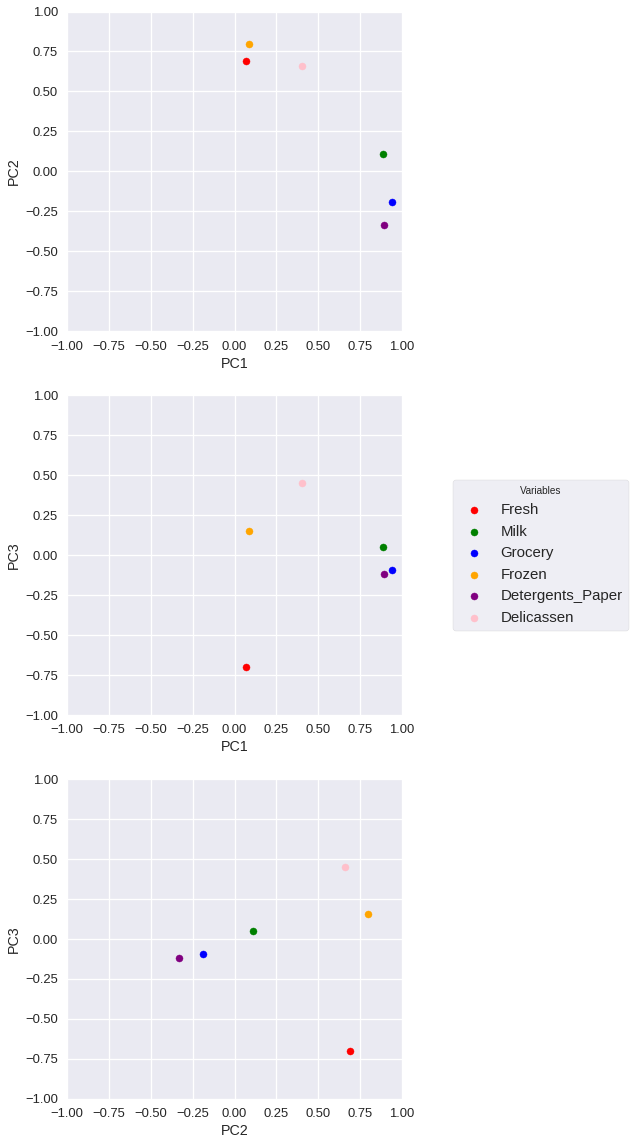

In [11]:
colorlist = ['red','green', 'blue', 'orange', 'purple', 'pink']

fig, (ax1, ax2, ax3) = plt.subplots(3)
[loadings.ix[[i]].plot.scatter(x='PC1', y='PC2', figsize=(6,20),
                               ax=ax1, 
                               ylim=[-1,1],
                               xlim=[-1,1],
                               s=50, 
                               color=colorlist[i % len(colorlist)])
                               for i,l in enumerate(cont_vars)]

[loadings.ix[[i]].plot.scatter(x='PC1', y='PC3',
                               ylim=[-1,1],
                               xlim=[-1,1],
                               ax=ax2, 
                               s=50,
                               label=cont_vars[i],
                               color=colorlist[i % len(colorlist)])
                               for i,l in enumerate(cont_vars)]

ax2.legend(loc='center right', 
           bbox_to_anchor=(1.7, 0.5), 
           title='Variables',
           frameon=True,
           fontsize=15)

[loadings.ix[[i]].plot.scatter(x='PC2', y='PC3',
                               ylim=[-1,1],
                               xlim=[-1,1],
                               ax=ax3, 
                               s=50,
                               color=colorlist[i % len(colorlist)])
                               for i,l in enumerate(cont_vars)]



###### PCA scores

In [29]:
# Make a dataframe with PCA scores for each observation 
# then append the respective Region and Channel.

dfs = pd.DataFrame(pca.fit_transform(X_std))
dfs.columns = ['PC'+str(i+1) for i in range(len(dfs.columns))]
dfs = dfs[['PC1', 'PC2', 'PC3']]
dfs['Region'] = df.Region
dfs['Channel'] = df.Channel

# Check the dataframe
dfs.head()

,PC1,PC2,PC3,Region,Channel
0,0.193291,-0.305100,-0.140878,3,2
1,0.434420,-0.328413,0.319007,3,2
2,0.811143,0.815096,1.523416,3,2
3,-0.778648,0.652754,0.163012,3,1
4,0.166287,1.271434,0.066279,3,2


### PCA scores plot (by Region)

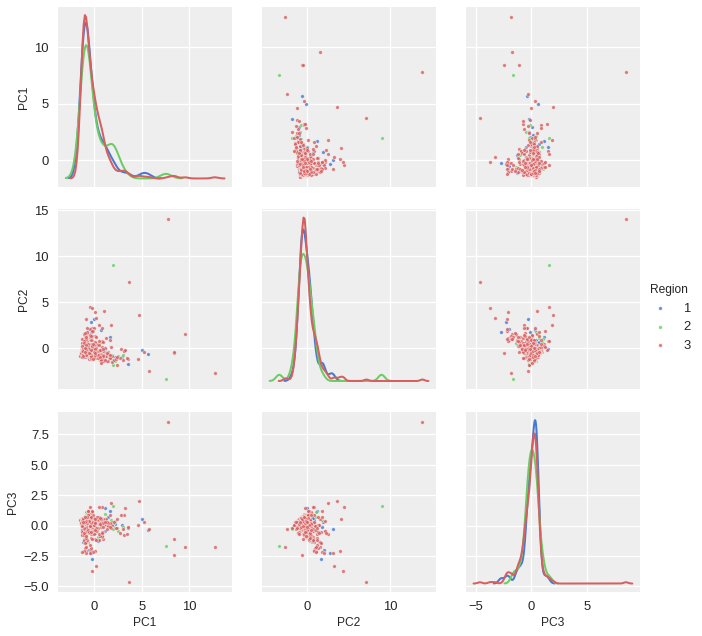

In [18]:
g = sns.pairplot(dfs, size=3,  palette="muted", vars=["PC1", "PC2", "PC3"], 
                 hue='Region', diag_kind="kde", markers='.', 
                 plot_kws=dict(s=55, alpha=.8))

- There aren't obvious differences between customers in different regions. The three regions have very similiar distributions for each component extracted. Lisbon (region 1) has slightly higher PC1 values than Oporto (2) and Others (3). 

### PCA score plots (by Channel)

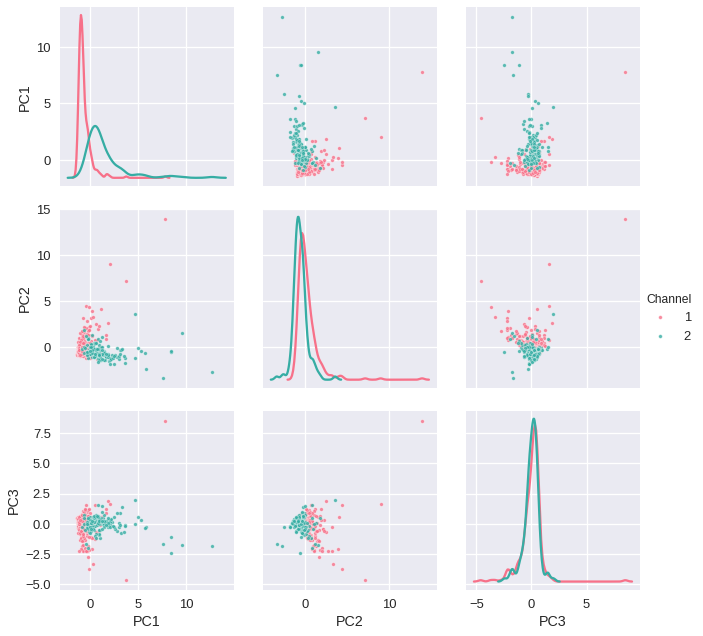

In [14]:
g = sns.pairplot(dfs, size=3,  palette="husl", vars=["PC1", "PC2", "PC3"], 
                 hue='Channel', diag_kind="kde", markers='.', 
                 plot_kws=dict(s=55, alpha=.8))

#### Scores interpretation

- Customers who spent more on Milk, Groceries and Detergents/Paper (PC1) tend to be Retail customers (Channel 2). 

- There are no differences amongst customer channels represented by the third component, PC3, which mostly represents customers who buy mostly Delicassen and not any Fresh products at all. 

- Customers who spent more on Fresh, Frozen and Delicassen (PC2) tend to be slightly more HoReCa customers (Channel 1). 

- There seems to be no difference in the customers regions by their segment. 

In [15]:
#This chunk is related to Jupyter notebook aesthetics.

import json
from IPython.core.display import HTML
from pylab import rcParams
%matplotlib inline

s = json.load( open("/home/hypathia/bmh_matplotlibrc.json") )  #edit path to json file
rcParams.update(s)
rcParams['figure.figsize'] = 6, 6

def css_styling():
    styles = open("/home/hypathia/custom.css", "r").read() #or edit path to custom.css
    return HTML(styles)

css_styling()
